In [1]:
from keras import layers, models
class AE(models.Model):
    # x_nodes 입력노드수, z_dim 은닉노드수
    # 24x24(픽셀 784개) 입력 이미지들이 원소 36개로 구성된 벡터로 변환된 뒤
    # 24x24 이미지로 복구됨
    def __init__(self, x_nodes=784, z_dim=36):
        x_shape = (x_nodes,)
        #입력 계층
        x = layers.Input(shape=x_shape)
        #은닉 계층
        z = layers.Dense(z_dim, activation='relu')(x)
        #출력 계층
        y = layers.Dense(x_nodes, activation='sigmoid')(z)
        super().__init__(x, y)
        self.x = x
        self.z = z
        self.z_dim = z_dim

        self.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #신경망 외부에서 부호화 결과를 확인하고 싶을 때 호출할 함수
    def Encoder(self):
        return models.Model(self.x, self.z)
    
    #복호화를 수행하는 함수
    def Decoder(self):
        z_shape = (self.z_dim,)
        z = layers.Input(shape=z_shape)
        # 제일 마지막 레이어가 출력 계층
        y_layer = self.layers[-1]
        y = y_layer(z)
        return models.Model(z, y)

In [2]:
from keras.datasets import mnist
import numpy as np
# 데이터 로딩
# 레이블 정보는 _로 전달받음, 추후 사용되지 않는
# 함수의 리턴값을 받는 변수는 밑줄 _ 사용을 권장함
# AE는 비지도학습이기에 레이블을 필요로 하지 않음
# 입력데이터를 출력데이터에 똑같이 사용함
(X_train, _), (X_test, _) = mnist.load_data()
#입력값이 1 이하가 되도록 정규화시킴
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
print(X_train.shape)

(60000, 28, 28)


In [3]:
#3차원에서 2차원 형태로 모양을 바꿈(차원 축소)
# len(X_train) 이미지수, np.prod(X_train.shape[1:]) 이미지 길이
#print(X_train.shape[1:]) #(28,28)
X_train = X_train.reshape(len(X_train), 784)
X_test = X_test.reshape(len(X_test), 784)
print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


In [4]:
#파라미터 설정(입력노드수 784, 부호화 벡터 길이 36 -
# 길이가 784인 원래 이미지의 데이터 길이가 36으로 압축됨)
x_nodes = 784
z_dim = 36
#모델 생성
autoencoder = AE(x_nodes, z_dim)
#모델 학습
#입력데이터와 출력데이터를 동일하게 설정
# fit(입력데이터,출력데이터)
history = autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, validation_split=0.2)

Epoch 1/50
188/188 [==============================] - 2s 6ms/step - loss: 0.2918 - accuracy: 0.0121 - val_loss: 0.2054 - val_accuracy: 0.0140
Epoch 2/50
188/188 [==============================] - 1s 5ms/step - loss: 0.1822 - accuracy: 0.0139 - val_loss: 0.1635 - val_accuracy: 0.0143
Epoch 3/50
188/188 [==============================] - 1s 5ms/step - loss: 0.1522 - accuracy: 0.0115 - val_loss: 0.1420 - val_accuracy: 0.0094
Epoch 4/50
188/188 [==============================] - 1s 5ms/step - loss: 0.1349 - accuracy: 0.0105 - val_loss: 0.1282 - val_accuracy: 0.0103
Epoch 5/50
188/188 [==============================] - 1s 5ms/step - loss: 0.1237 - accuracy: 0.0097 - val_loss: 0.1193 - val_accuracy: 0.0093
Epoch 6/50
188/188 [==============================] - 1s 5ms/step - loss: 0.1157 - accuracy: 0.0097 - val_loss: 0.1124 - val_accuracy: 0.0087
Epoch 7/50
188/188 [==============================] - 1s 5ms/step - loss: 0.1097 - accuracy: 0.0104 - val_loss: 0.1074 - val_accuracy: 0.0082
Epoch 

In [5]:
def plot_acc(history, title=None):
    if not isinstance(history,dict):
        history=history.history
    plt.plot(history["accuracy"])
    plt.plot(history["val_accuracy"])
    if title is not None:
        plt.title(title)
    plt.ylabel("정확도")
    plt.xlabel("에포크")
    plt.legend(["학습 데이터 성능","검증 데이터 성능"],loc=0)

In [6]:
def plot_loss(history,title=None):
    if not isinstance(history,dict):
        history=history.history
    plt.plot(history["loss"])
    plt.plot(history["val_loss"])
    if title is not None:
        plt.title(title)
    plt.ylabel("손실")
    plt.xlabel("에포크")
    plt.legend(["학습 데이터 성능","검증 데이터 성능"],loc=0)

In [7]:
def plot_loss_acc(history):
    plot_loss(history,"손실 추이")
    plt.show()
    plot_acc(history,"정확도 추이")
    plt.show()

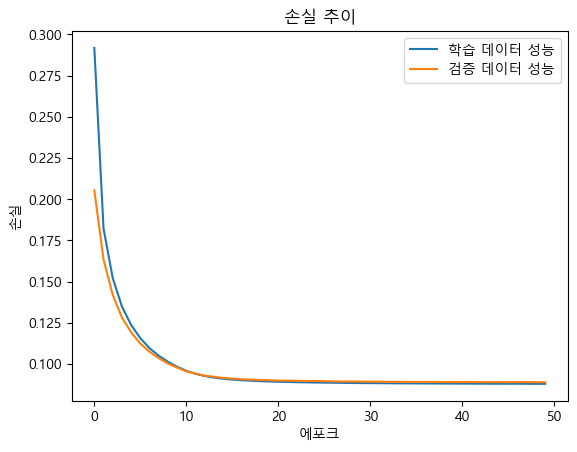

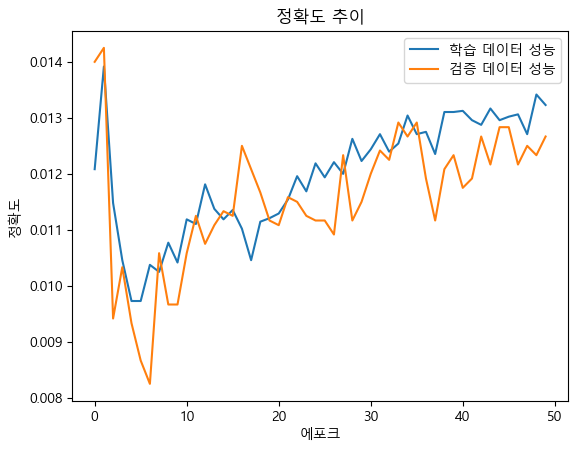

In [8]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_location = 'c:/windows/fonts/malgun.ttf'
font_name = font_manager.FontProperties(fname=font_location).get_name()
rc('font', family=font_name)
plot_loss_acc(history)
#손실값 : 부호화 후 복호화한 이미지와 원 이미지가 얼마나 유사한지를 나타냄,
# 손실값이 작을수록 부호화가 잘된 것
# 입력데이터(학습에 사용되지 않은 숫자 이미지)
# 부호화 결과
# 출력이미지

In [9]:
def show_ae(autoencoder):
    #부호화,복호화 모델의 인스턴스 생성
    encoder = autoencoder.Encoder()
    decoder = autoencoder.Decoder()
    encoder.summary()
    decoder.summary()
    #평가용 이미지들을 넣어서 부호화 결과와 복호화 결과 생성
    encoded_imgs = encoder.predict(X_test)
    #부호화된 이미지를 넣어서 복호화 데이터를 생성함
    decoded_imgs = decoder.predict(encoded_imgs)
    #화면에 표시할 이미지의 수
    n = 10
    #subplot 방식을 사용하여 10개를 하나의 그래프로 그리기 위해
    # 그림의 전체 크기를 20,6으로 설정
    plt.figure(figsize=(20, 6))
    for i in range(n):
        ax = plt.subplot(3, n, i + 1)
        #입력 이미지(평가용 이미지)
        plt.imshow(X_test[i].reshape(28, 28))
        #흑백으로 출력
        plt.gray()
        #이미지 주변 축들이 보이지 않게 함
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(3, n, i + 1 + n)
        #이미지가 압축된 형태(2차원 이미지를 1차원의 벡터로 압축)
        plt.stem(encoded_imgs[i].reshape(-1))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(3, n, i + 1 + n + n)
        #복호화한 이미지 출력
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 36)                28260     
                                                                 
Total params: 28,260
Trainable params: 28,260
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 36)]              0         
                                                                 
 dense_1 (Dense)             (None, 784)               29008     
                                                                 
Total params: 29,008
Trainable params: 2

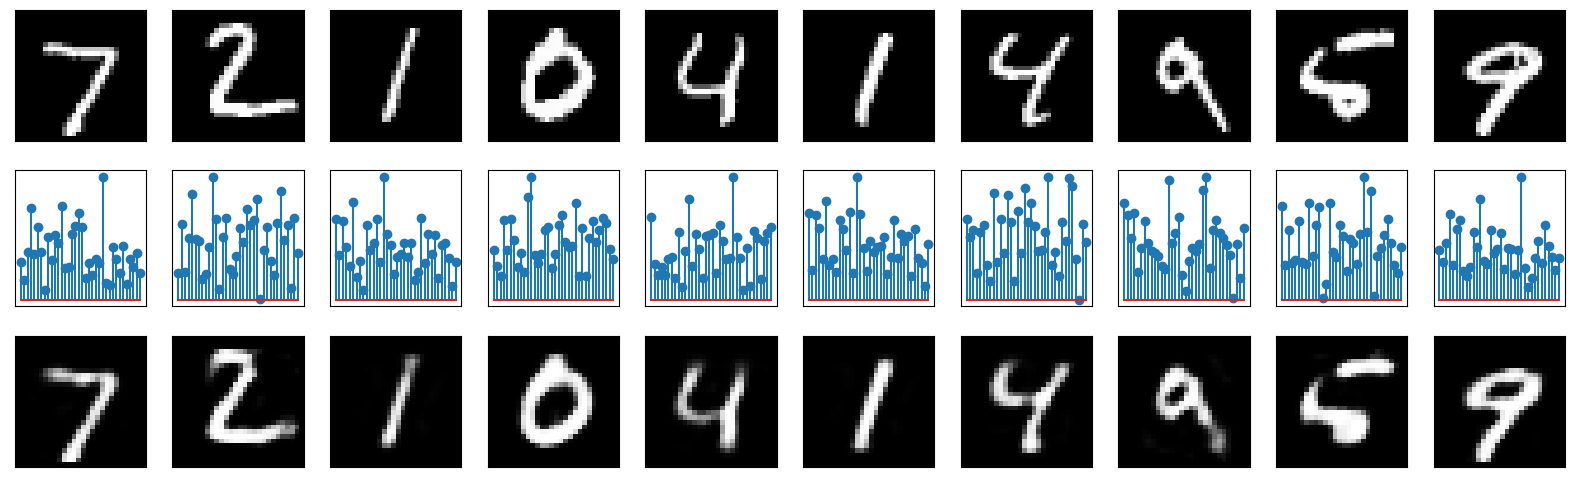

In [10]:
show_ae(autoencoder)